In [7]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=2., rc={"lines.linewidth": 4.5})
sns.set_style("whitegrid")

palette = sns.color_palette("Paired")
new_palette = palette
new_palette[0] = palette[8]
new_palette[1] = palette[9]
new_palette[8] = palette[0]
new_palette[9] = palette[1]

sns.set_palette(new_palette)

In [8]:
def wandb_metrics(sweep_id, keys=None, config_keys=None, summary=True):
    sweep = wandb.Api().sweep(sweep_id)
    if isinstance(keys, list):
        keys.extend(['_runtime', '_step', '_timestamp'])
        keys = list(set(keys))

    data = []
    for run in sweep.runs:
        cfg = {k: run.config[k] for k in config_keys}
        if summary:
            data.append({ **cfg, **run.summary })
        else:
            for row in run.scan_history(keys=keys):
                data.append(dict(run_id=run.id, **cfg, **row))
    
    return sweep, pd.DataFrame(data)

config_keys = ['dataset', 'lbfgs', 'lr', 'lanc_iter', 'pre_size', 'cg_tol']
dataset2id = dict(
    bike='gausspr/gp-lbfgs/mtprago6',
    elevators='gausspr/gp-lbfgs/i2jeqn9b',
    protein='gausspr/gp-lbfgs/bdtcwoow'
)

## Change this and re-run everything.
dataset = 'elevators'

In [9]:
_, metrics = wandb_metrics(dataset2id[dataset], config_keys=config_keys)

## Varying Root Decomposition Size

### NLL

The best test NLL achieved, selected via best validation loss.

The typical trend is that higher rank and lower CG tolerance lead to better performance with LBFGS.

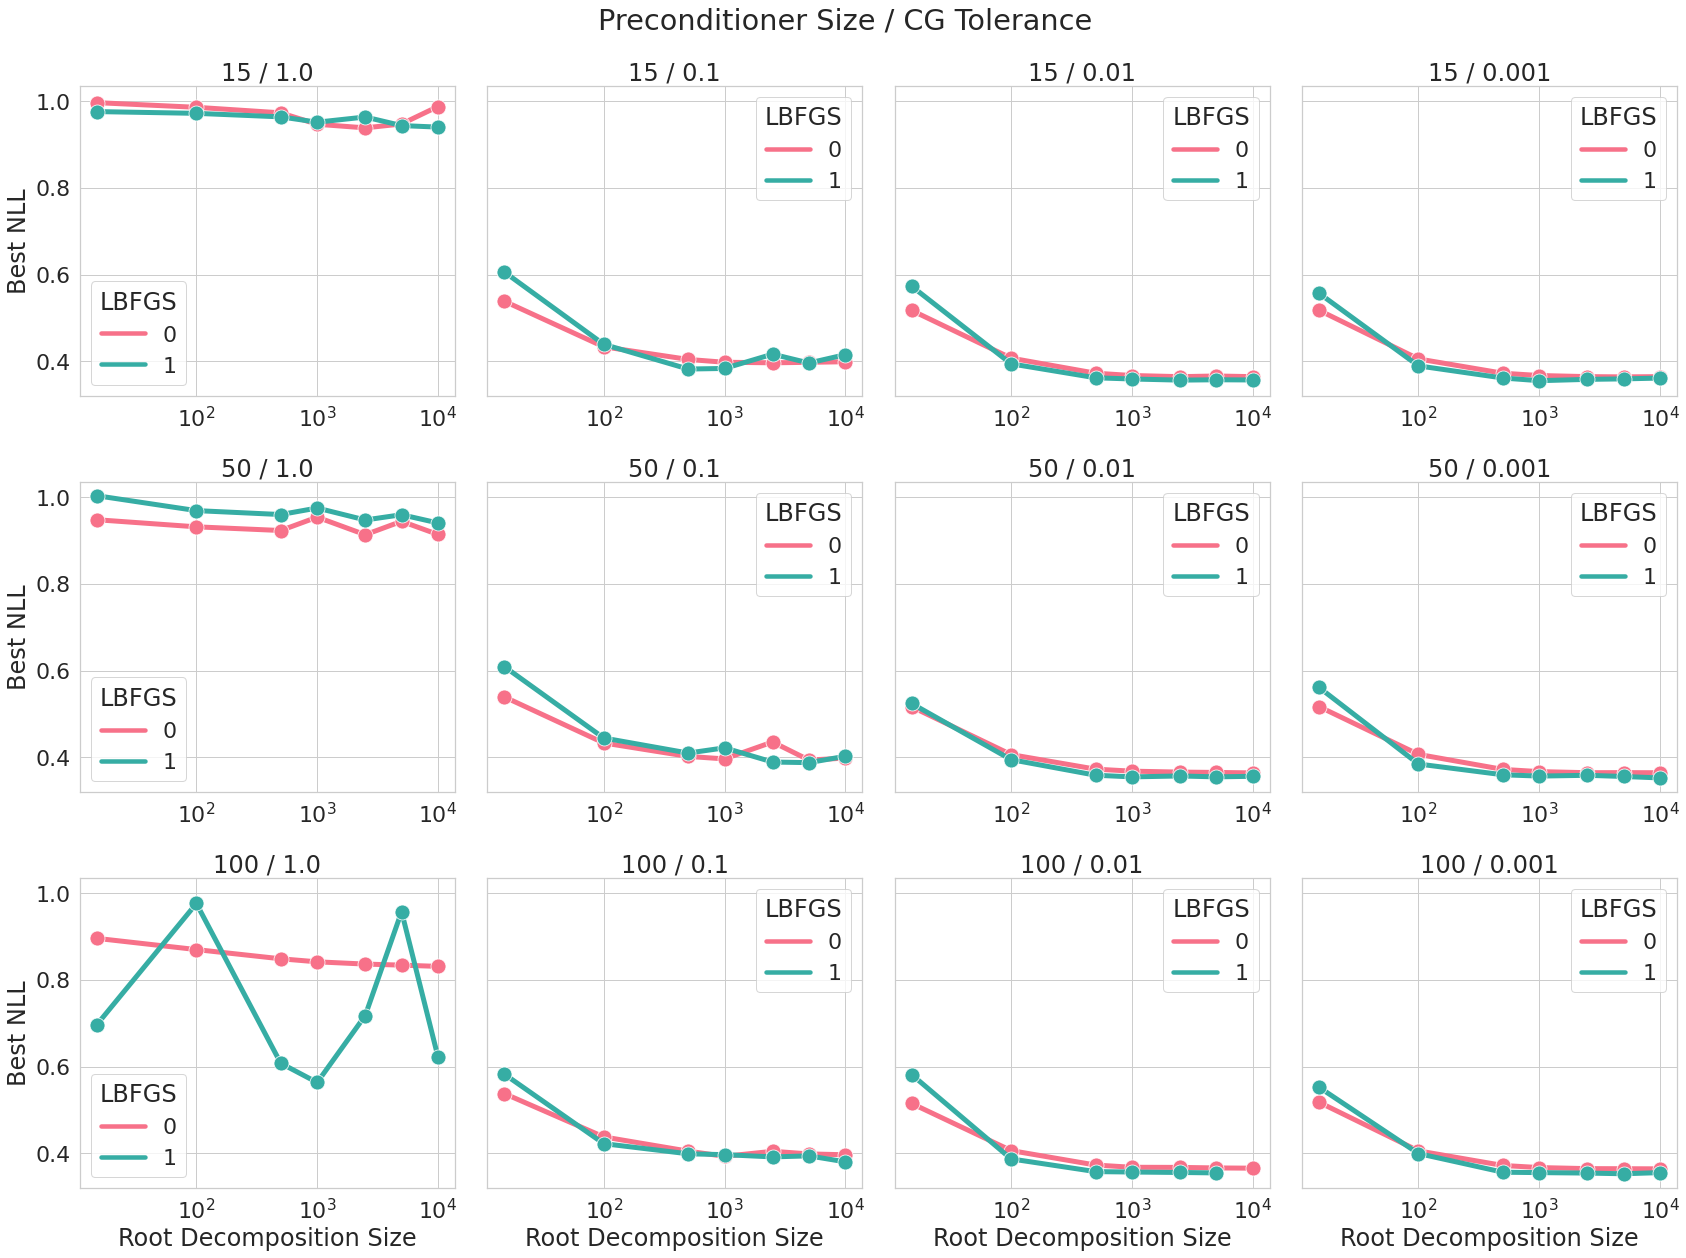

In [10]:
fig, axes = plt.subplots(
    figsize=(24, 18), nrows=len(metrics.pre_size.unique()), ncols=len(metrics.cg_tol.unique()),
    sharex=False, sharey=True,
)

for i, pre_size in enumerate(sorted(metrics.pre_size.unique())):
    for j, cg_tol in enumerate(sorted(metrics.cg_tol.unique(), reverse=True)):
        sns.lineplot(ax=axes[i,j],
                     data=metrics[(metrics.pre_size == pre_size) & (metrics.cg_tol == cg_tol)],
                     x='lanc_iter', y='test/best_nll', hue='lbfgs',
                     marker='o', markersize=15, linewidth=5, palette=sns.color_palette('husl', 2))
        axes[i,j].set_title(f'{pre_size} / {cg_tol}')
        axes[i,j].set_xticks(sorted(metrics.lanc_iter.unique()))
        axes[i,j].set_xscale('log')
        axes[i,j].set_xlabel('Root Decomposition Size' if i == 2 else '')
        axes[i,j].set_ylabel('Best NLL' if j == 0 else '')
        axes[i,j].legend(title='LBFGS')

fig.suptitle('Preconditioner Size / CG Tolerance')
# fig.supxlabel(r'CG Tolerance $\longrightarrow$')
# fig.supylabel(r'$\longleftarrow$ Preconditioner Size')
fig.tight_layout()

### RMSE

The corresponding test RMSE, for the best test NLL. This may not always be better.

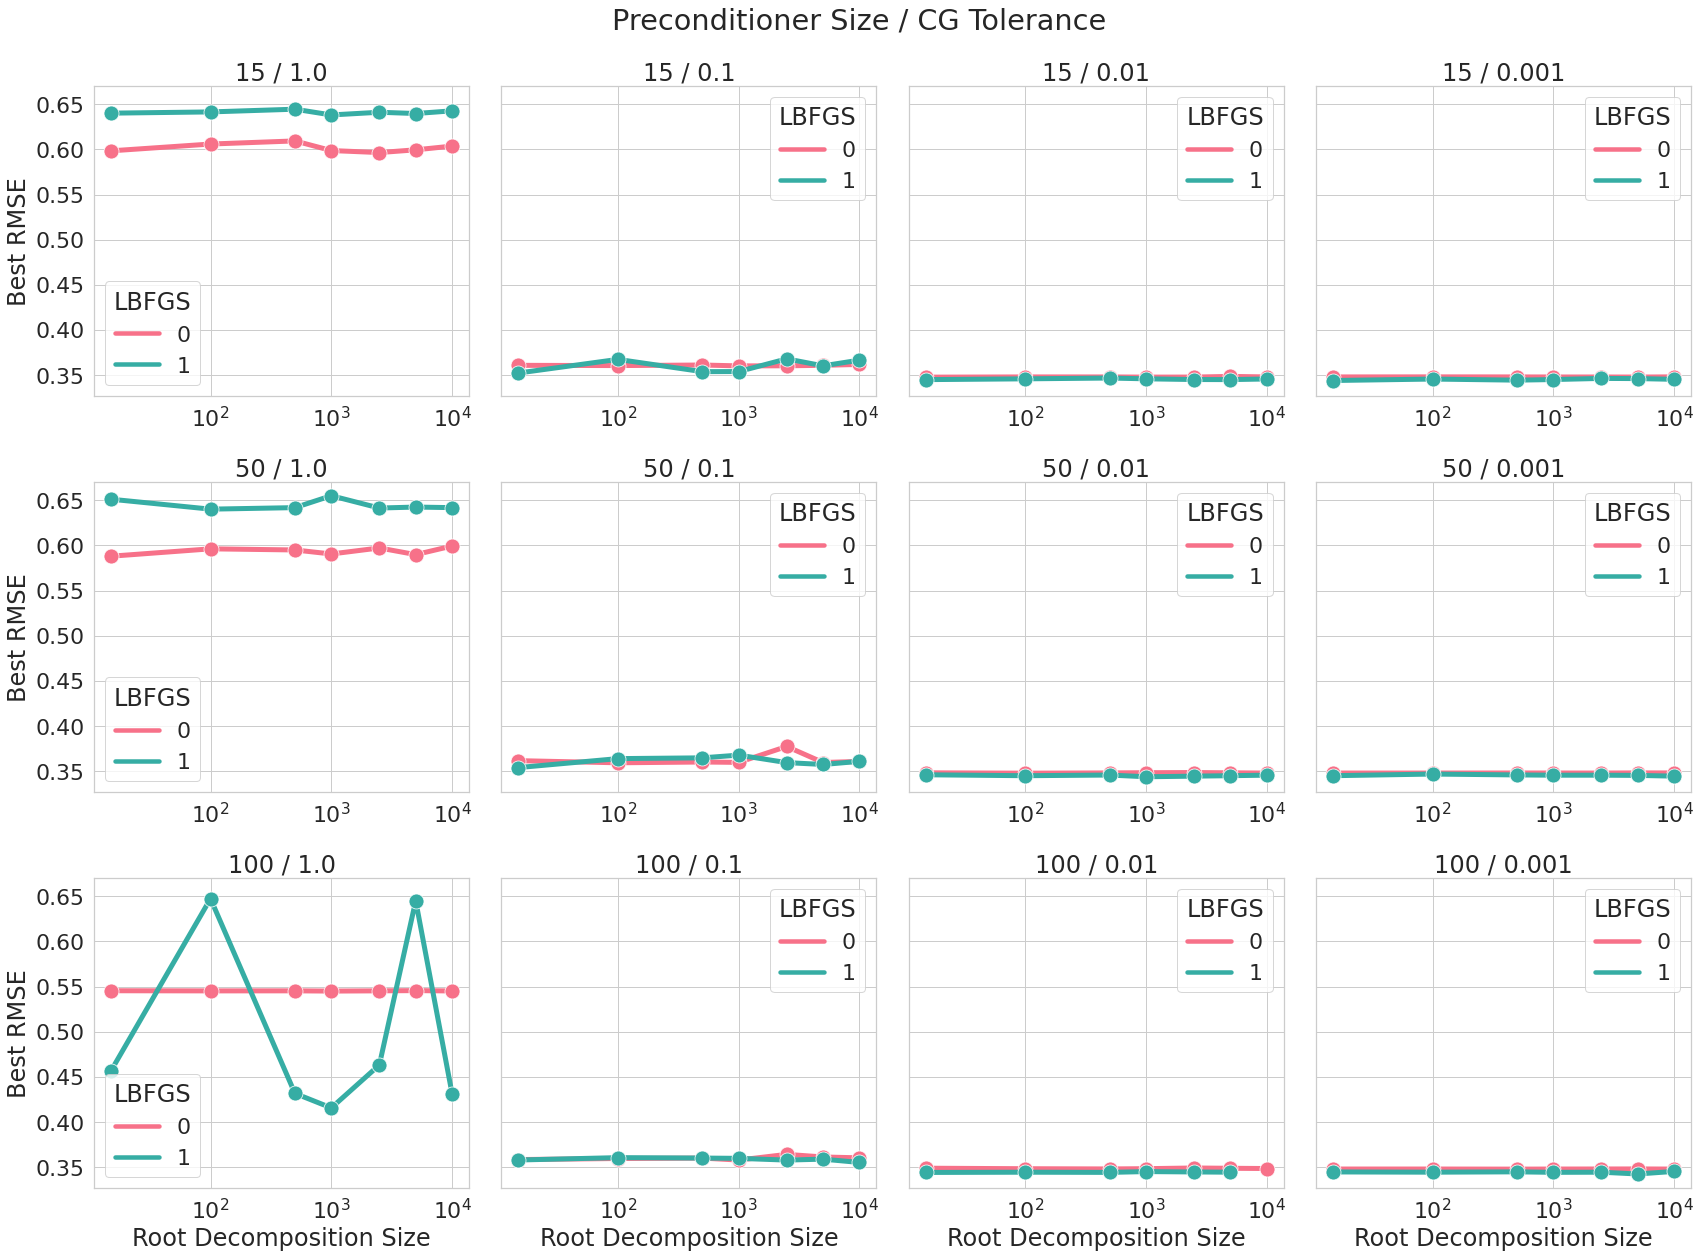

In [11]:
fig, axes = plt.subplots(
    figsize=(24, 18), nrows=len(metrics.pre_size.unique()), ncols=len(metrics.cg_tol.unique()),
    sharey=True
)

for i, pre_size in enumerate(sorted(metrics.pre_size.unique())):
    for j, cg_tol in enumerate(sorted(metrics.cg_tol.unique(), reverse=True)):
        sns.lineplot(ax=axes[i,j],
                     data=metrics[(metrics.pre_size == pre_size) & (metrics.cg_tol == cg_tol)],
                     x='lanc_iter', y='test/best_rmse', hue='lbfgs',
                     marker='o', markersize=15, linewidth=5, palette=sns.color_palette('husl', 2))
        axes[i,j].set_title(f'{pre_size} / {cg_tol}')
        axes[i,j].set_xscale('log')
        axes[i,j].set_xlabel('Root Decomposition Size' if i == 2 else '')
        axes[i,j].set_ylabel('Best RMSE' if j == 0 else '')
        axes[i,j].legend(title='LBFGS')

fig.suptitle('Preconditioner Size / CG Tolerance')
# fig.supxlabel(r'CG Tolerance $\longrightarrow$')
# fig.supylabel(r'$\longleftarrow$ Preconditioner Size')
fig.tight_layout()

## Varying Tolerance

The same conclusion as earlier, just plotting different variables.

### NLL

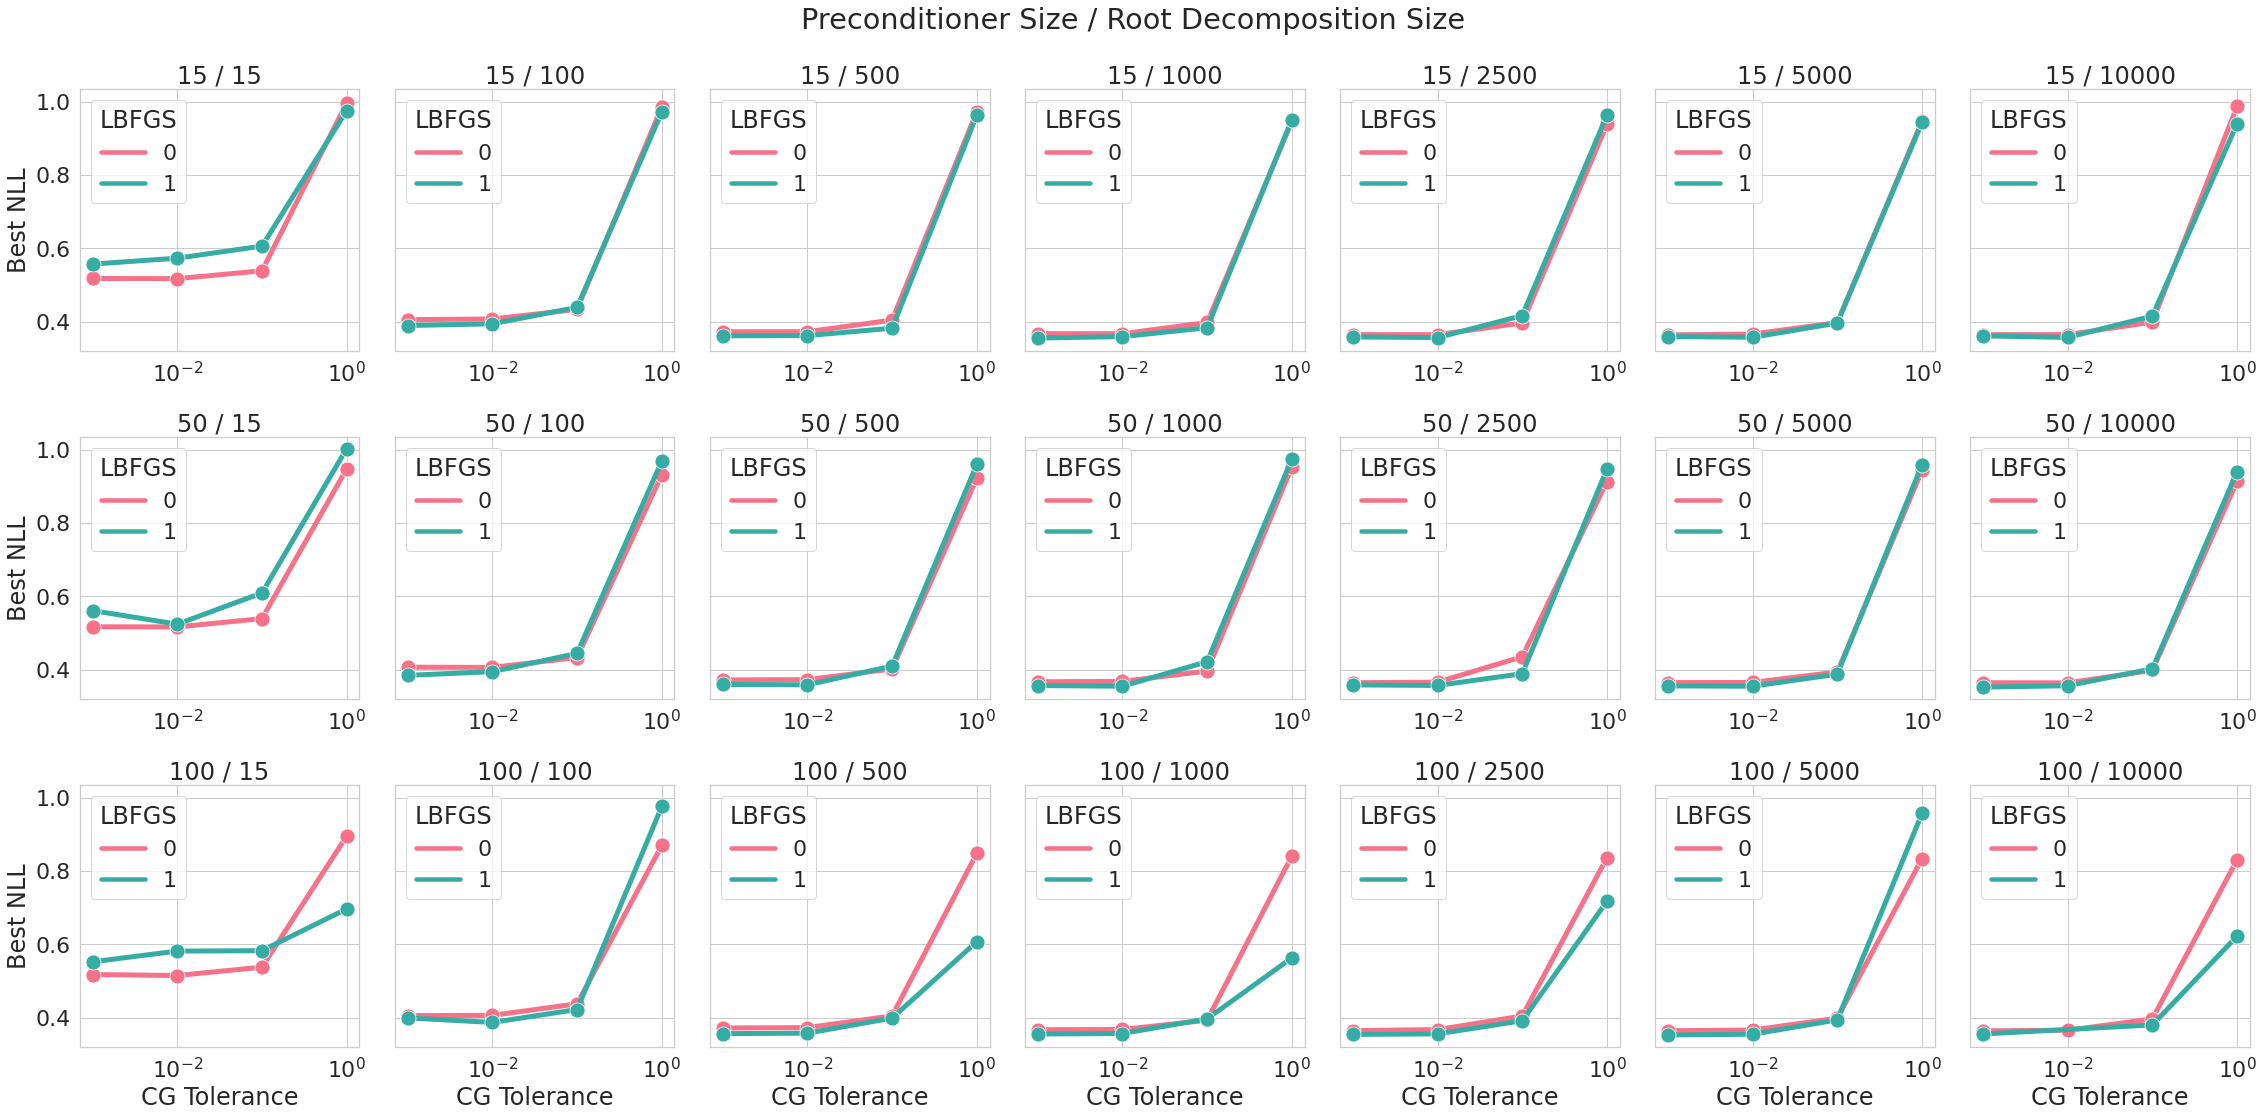

In [12]:
fig, axes = plt.subplots(
    figsize=(32, 16), ncols=len(metrics.lanc_iter.unique()), nrows=len(metrics.pre_size.unique()),
    sharey=True,
)

for i, pre_size in enumerate(sorted(metrics.pre_size.unique())):
    for j, lanc_iter in enumerate(sorted(metrics.lanc_iter.unique())):
        sns.lineplot(ax=axes[i,j],
                     data=metrics[(metrics.pre_size == pre_size) & (metrics.lanc_iter == lanc_iter)],
                     x='cg_tol', y='test/best_nll', hue='lbfgs',
                     marker='o', markersize=15, linewidth=5, palette=sns.color_palette('husl', 2))
        axes[i,j].set_title(f'{pre_size} / {lanc_iter}')
        axes[i,j].set_xscale('log')
        axes[i,j].set_xlabel('CG Tolerance' if i == 2 else '')
        axes[i,j].set_ylabel('Best NLL' if j == 0 else '')
        axes[i,j].legend(title='LBFGS')

fig.suptitle('Preconditioner Size / Root Decomposition Size')
# fig.supxlabel(r'Root Decomposition Size $\longrightarrow$')
# fig.supylabel(r'$\longleftarrow$ Preconditioner Size')
fig.tight_layout()

### RMSE

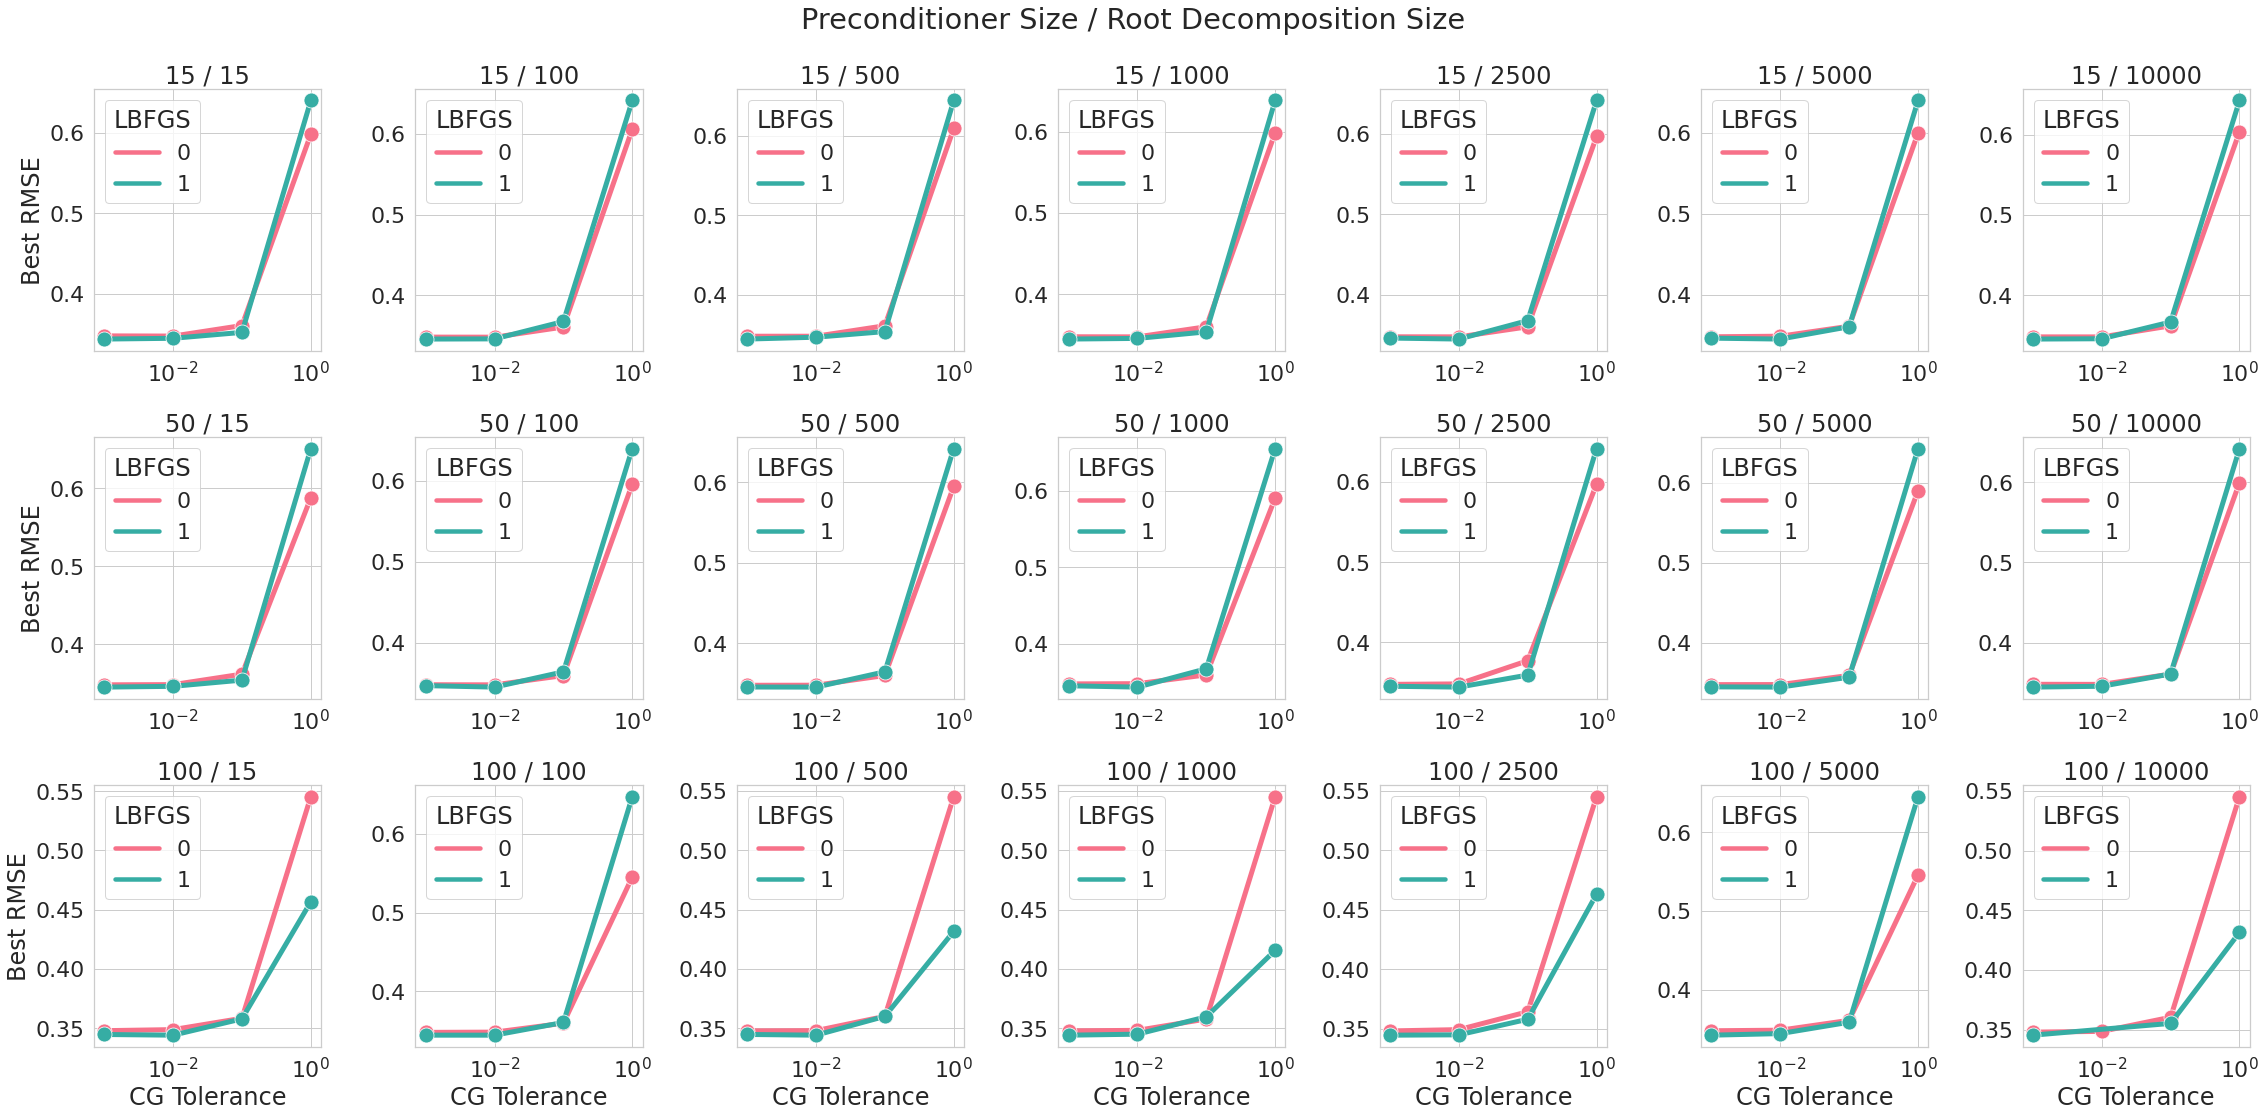

In [13]:
fig, axes = plt.subplots(figsize=(32, 16), ncols=len(metrics.lanc_iter.unique()), nrows=len(metrics.pre_size.unique()))

for i, pre_size in enumerate(sorted(metrics.pre_size.unique())):
    for j, lanc_iter in enumerate(sorted(metrics.lanc_iter.unique())):
        sns.lineplot(ax=axes[i,j],
                     data=metrics[(metrics.pre_size == pre_size) & (metrics.lanc_iter == lanc_iter)],
                     x='cg_tol', y='test/best_rmse', hue='lbfgs',
                     marker='o', markersize=15, linewidth=5, palette=sns.color_palette('husl', 2))
        axes[i,j].set_title(f'{pre_size} / {lanc_iter}')
        axes[i,j].set_xticks(sorted(metrics.cg_tol.unique()))
        axes[i,j].set_xscale('log')
        axes[i,j].set_xlabel('CG Tolerance' if i == 2 else '')
        axes[i,j].set_ylabel('Best RMSE' if j == 0 else '')
        axes[i,j].legend(title='LBFGS')

fig.suptitle('Preconditioner Size / Root Decomposition Size')
# fig.supxlabel(r'Root Decomposition Size $\longrightarrow$')
# fig.supylabel(r'$\longleftarrow$ Preconditioner Size')
fig.tight_layout()

## Training Time

The general trend here is that LBFGS achieves better Train MLL and Test RMSE in fewer epochs. But epochs take far longer with LBFGS than Adam, as expected. LBFGS curves also appear to be far less stable.

In [14]:
dataset = 'protein'
_, metrics = wandb_metrics(dataset2id[dataset], config_keys=config_keys, summary=False)

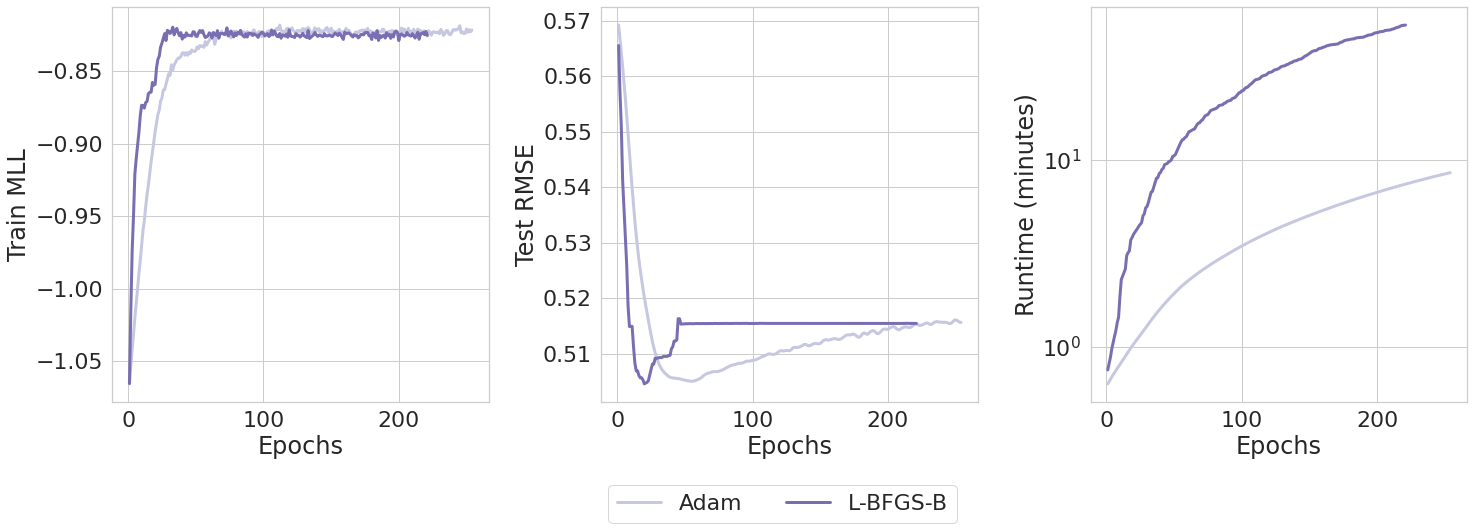

In [15]:
plt_data = metrics[(metrics.cg_tol == 1e-3) & (metrics.pre_size == 100) & (metrics.lanc_iter == 10000)].copy()
plt_data['train/total_cu_ts'] = plt_data.groupby(by=['run_id'])['train/total_ts'].cumsum() / 60
plt_data['Optimizer'] = plt_data['lbfgs'].apply(lambda v: 'L-BFGS-B' if v else 'Adam')
plt_data = plt_data.sort_values(by=['Optimizer'])

fig, axes = plt.subplots(figsize=(21,7), ncols=3, sharex=True)

sns.lineplot(ax=axes[0], data=plt_data,
             x='_step', y='train/mll', hue='Optimizer', palette=sns.color_palette('Purples', 2), linewidth=3)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train MLL')
axes[0].legend().set_visible(False)

sns.lineplot(ax=axes[1], data=plt_data,
             x='_step', y='test/rmse', hue='Optimizer', palette=sns.color_palette('Purples', 2), linewidth=3)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Test RMSE')
axes[1].legend().set_visible(False)

sns.lineplot(ax=axes[2], data=plt_data,
             x='_step', y='train/total_cu_ts', hue='Optimizer', palette=sns.color_palette('Purples', 2), linewidth=3)
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Runtime (minutes)')
axes[2].set_yscale('log')
axes[2].legend().set_visible(False)

handles, labels = axes[2].get_legend_handles_labels()
for h in handles:
    h.set(linewidth=3)

fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0.145, 0., .5, 0.),
           ncol=2, borderaxespad=0., frameon=True, title='')

# fig.suptitle('Protein')
fig.tight_layout()
# fig.savefig(f'{dataset}_perf.pdf', bbox_inches='tight')

### Train MLL

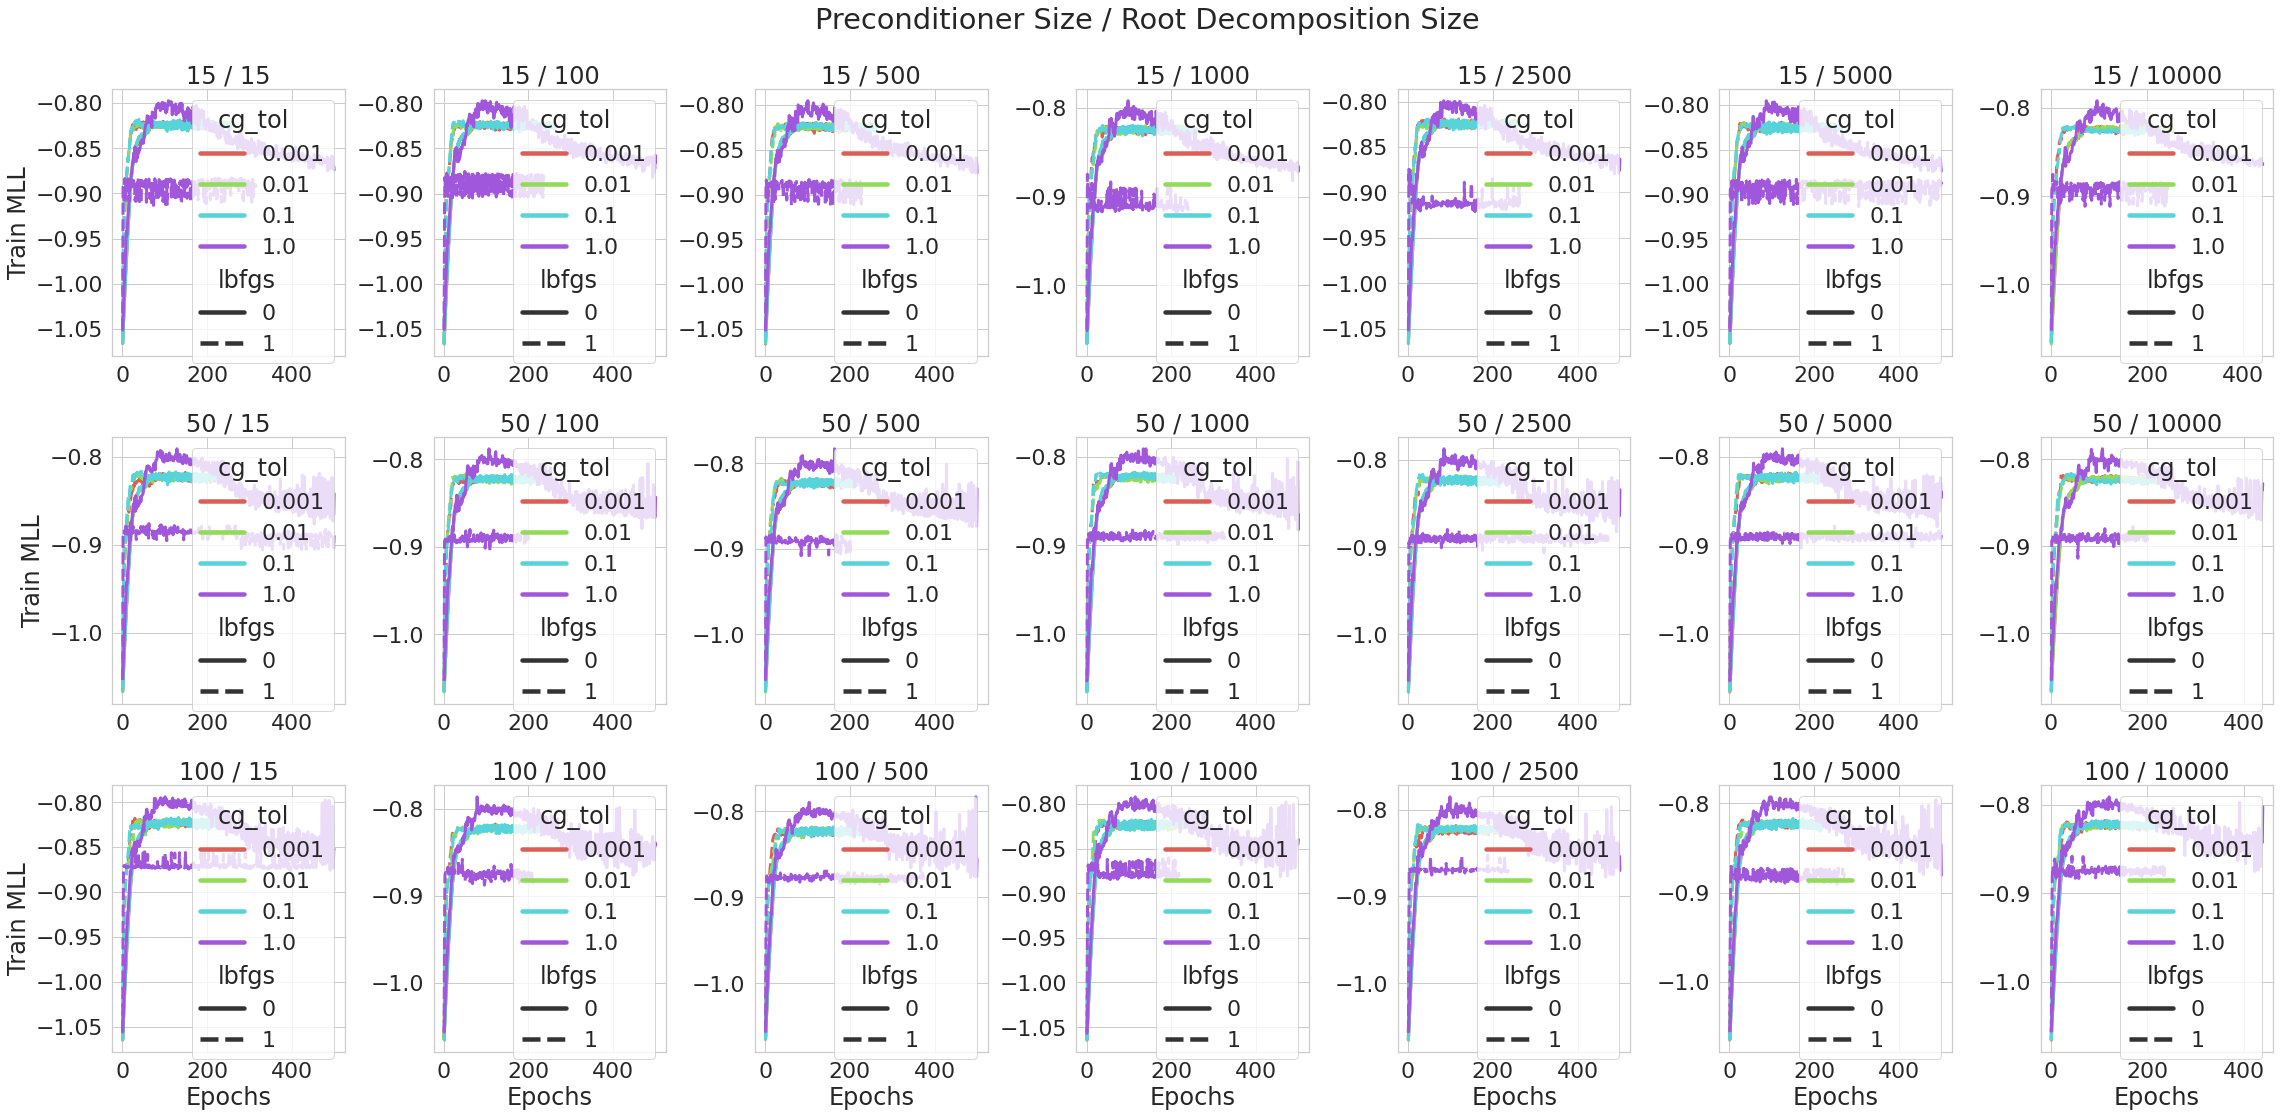

In [10]:
fig, axes = plt.subplots(figsize=(32, 16), ncols=len(metrics.lanc_iter.unique()), nrows=len(metrics.pre_size.unique()))

for i, pre_size in enumerate(sorted(metrics.pre_size.unique())):
    for j, lanc_iter in enumerate(sorted(metrics.lanc_iter.unique())):
        sns.lineplot(ax=axes[i,j],
                     data=metrics[(metrics.pre_size == pre_size) & (metrics.lanc_iter == lanc_iter)],
                     x='_step', y='train/mll', style='lbfgs', hue='cg_tol', palette=sns.color_palette('hls', 4),
                     linewidth=3)
        axes[i,j].set_title(f'{pre_size} / {lanc_iter}')
        axes[i,j].set_xlabel('Epochs' if i == 2 else '')
        axes[i,j].set_ylabel('Train MLL' if j == 0 else '')

fig.suptitle('Preconditioner Size / Root Decomposition Size')
# fig.supxlabel(r'Root Decomposition Size $\longrightarrow$')
# fig.supylabel(r'$\longleftarrow$ Preconditioner Size')
fig.tight_layout()

### Test RMSE

These curves are very noisy, probably not worth analyzing for now.

AttributeError: 'Figure' object has no attribute 'supxlabel'

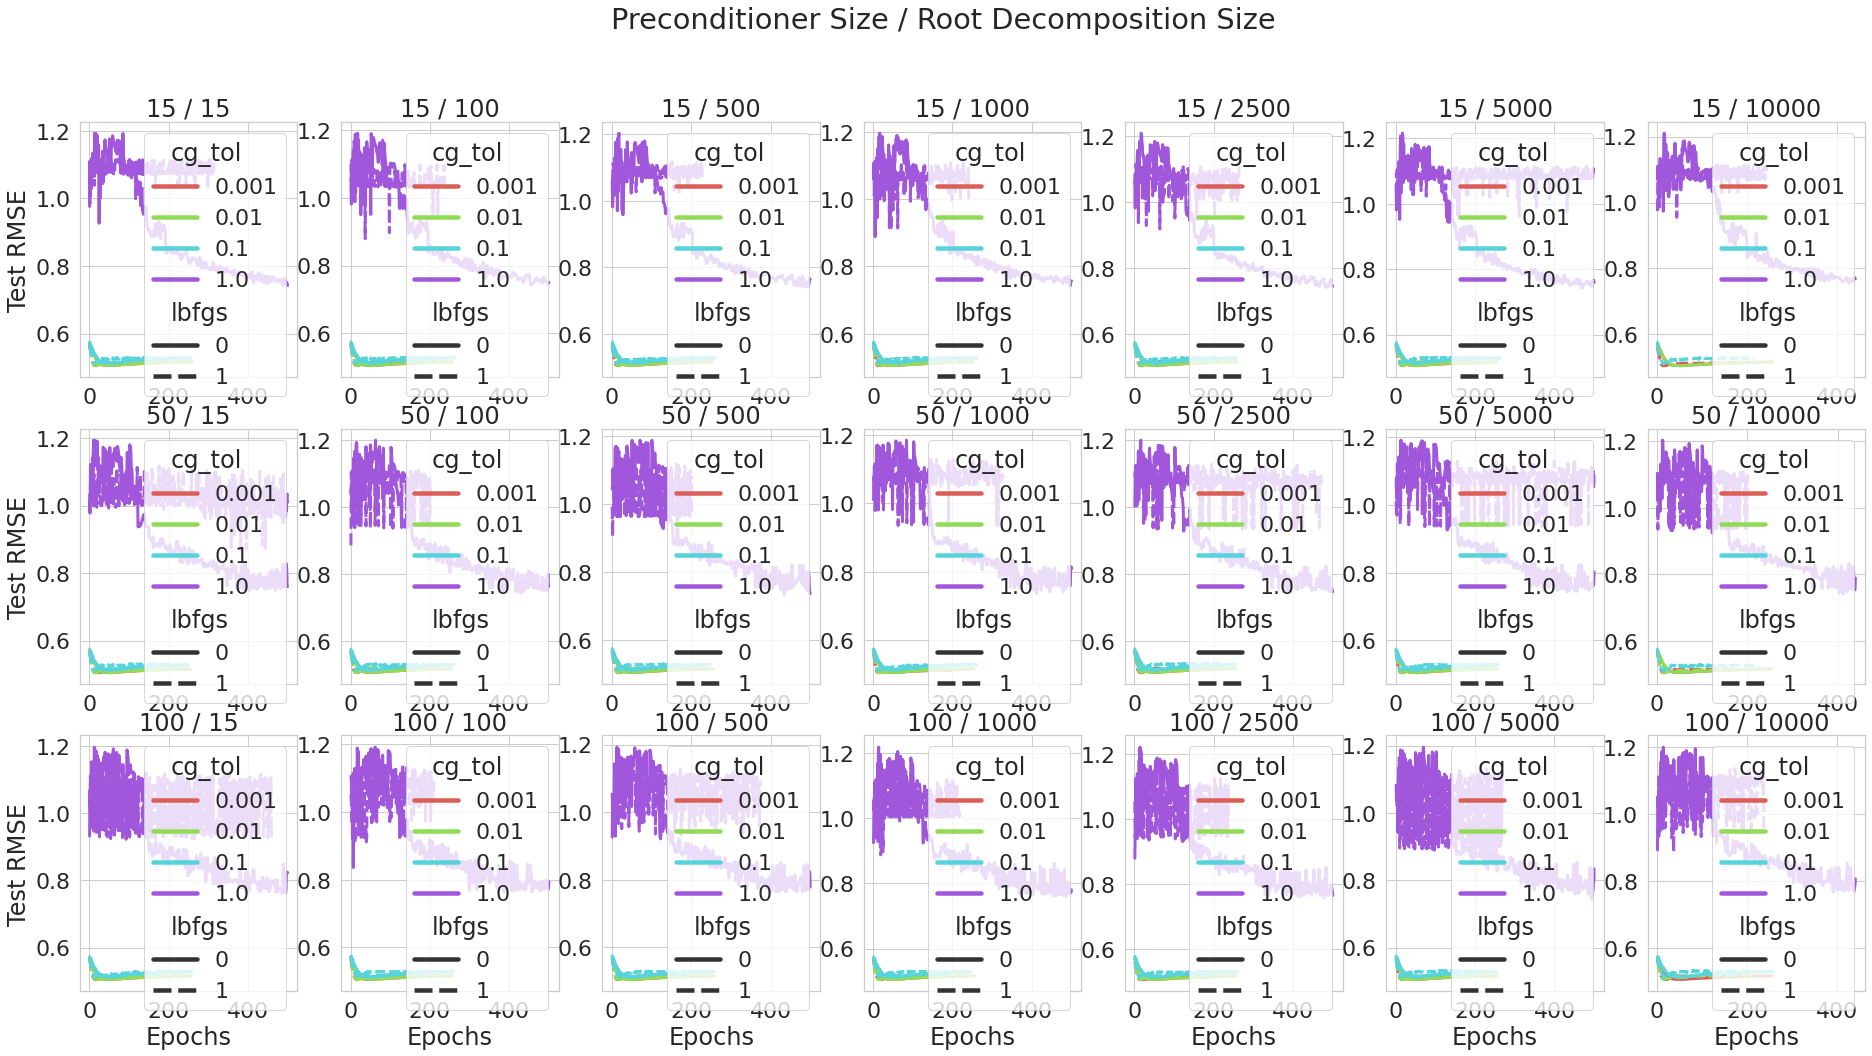

In [11]:
fig, axes = plt.subplots(figsize=(32, 16), ncols=len(metrics.lanc_iter.unique()), nrows=len(metrics.pre_size.unique()))

for i, pre_size in enumerate(sorted(metrics.pre_size.unique())):
    for j, lanc_iter in enumerate(sorted(metrics.lanc_iter.unique())):
        sns.lineplot(ax=axes[i,j],
                     data=metrics[(metrics.pre_size == pre_size) & (metrics.lanc_iter == lanc_iter)],
                     x='_step', y='test/rmse', style='lbfgs', hue='cg_tol', palette=sns.color_palette('hls', 4),
                     linewidth=3)
        axes[i,j].set_title(f'{pre_size} / {lanc_iter}')
        axes[i,j].set_xlabel('Epochs' if i == 2 else '')
        axes[i,j].set_ylabel('Test RMSE' if j == 0 else '')

fig.suptitle('Preconditioner Size / Root Decomposition Size')
fig.supxlabel(r'Root Decomposition Size $\longrightarrow$')
fig.supylabel(r'$\longleftarrow$ Preconditioner Size')
fig.tight_layout()

## Plots for Writeup

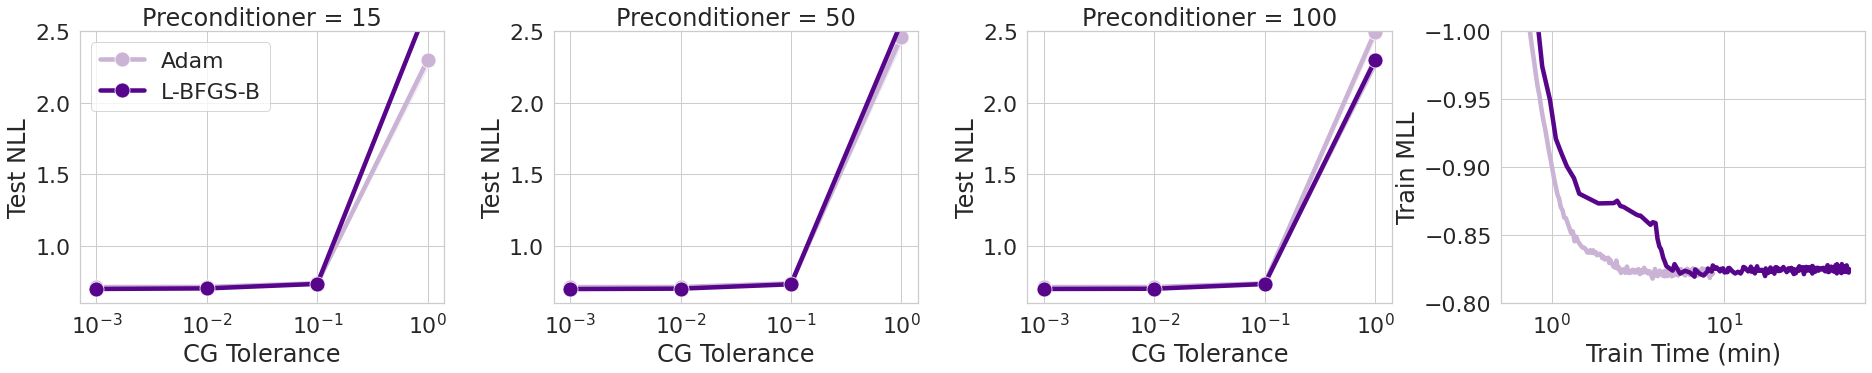

In [18]:
sub_df = metrics[(metrics.lanc_iter == 5000)]

fig, ax = plt.subplots(1, 4, figsize = (32, 5))

preconditioners = [15, 50, 100]
for i in range(3):
    legend = "auto" if i == 0 else False
        
    g = sns.lineplot(ax = ax[i], data=sub_df[(sub_df.pre_size == preconditioners[i])],
            y="test/nll", hue="lbfgs", x = "cg_tol", marker = ".", markersize=30, 
            legend = False, palette=["#cab3d5", "#57068c"],
    )
    if i == 0:
        new_labels = ["Adam", "L-BFGS-B"]
        ax[i].legend(
            ncol =1,
            labels=new_labels, loc = "upper left"
        )
    # for t, l in zip(g._legend.texts, new_labels): 
    #    t.set_text(l)
        
    ax[i].set_xscale('log')
    # ax[i].set_yscale("log")
    ax[i].set_xlabel("CG Tolerance")
    ax[i].set_ylabel("Test NLL")
    ax[i].set_ylim((0.6, 2.5))
    ax[i].set_title("Preconditioner = " + str(preconditioners[i]))
    
sns.lineplot(
    ax = ax[3], data = plt_data, x='train/total_cu_ts', y='train/mll', hue='lbfgs', legend = False,
    palette=["#cab3d5", "#57068c"],
)
ax[3].set_xscale("log")
ax[3].set_xlabel("Train Time (min)")
ax[3].set_ylabel("Train MLL")
ax[3].set_ylim((-0.8, -1.0))
plt.subplots_adjust(wspace = 0.3)
# plt.tight_layout()
plt.savefig("protein_lbfgs.pdf", bbox_inches = "tight")

In [68]:
!pwd

/home/wesley_m/bayesian_benchmarks/notebooks


<AxesSubplot:xlabel='train/total_cu_ts', ylabel='train/mll'>

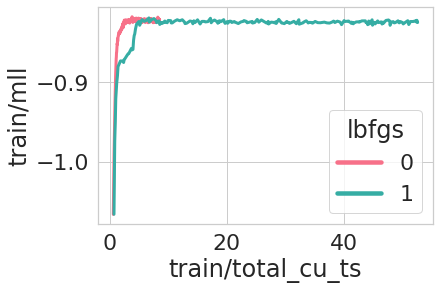

In [35]:
sns.lineplot(data=plt_data,
             x='train/total_cu_ts', y='train/mll', hue='lbfgs', palette=sns.color_palette('husl', 2), linewidth=3)
